In [2]:
pwd

'/home/jovyan/critical_feature_extraction/ipynb'

In [3]:
cd ..

/home/jovyan/critical_feature_extraction


In [141]:
%run __init__.py
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Clean Data:
1. Download 3 stocks' TI's
2. Check data
3. Drop unnessesary columns
4. concatenate the data

In [255]:
apple = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/AAPL_data.csv')

abbvie = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/ABBV_data.csv')

cvs = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/CVS_data.csv')

wfc = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/WFC_data.csv')

In [257]:
def clean_data(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    else:
        pass
    if 'Unnamed: 0.1' in df.columns:    
        df = df.drop('Unnamed: 0.1', axis=1)
    else:
        pass
    if 'Unnamed: 0.1.1' in df.columns:
        df = df.drop('Unnamed: 0.1.1', axis=1)
    else:
        pass
    df = df.set_index(pd.to_datetime(df.Date))
    df = df.drop('Date', axis=1)
    df = df.sort_index()
    df = pd.get_dummies(df)
    return df



In [258]:
apple = clean_data(apple)
cvs = clean_data(cvs)

wfc= clean_data(wfc)

abbvie = clean_data(abbvie)

multi_positions = pd.concat([apple, abbvie, wfc, cvs], axis=1)

multi_positions.shape

### Benchmarking with naive PCA and Linear Regression:
1. Prepare data for pipeline
2. Create a pipeline with:
    - Standardization
    - PCA
    - Linear Regression
3. Fit model
4. Produce scores
5. Visualize the Principal components

In [269]:
#define the y's as the current day's trading signal (because we shift the data in the next step we have to drop the first day)
y = multi_positions.iloc[1:, :].Target
#we shift the current days features to the previous days, so we can predict tomorrow's trading signal
multi_positions= multi_positions.iloc[:, 8:].shift()
#drop the NAN values created by the shift
multi_positions = multi_positions.dropna()
# define X's as the features without the targets
X = multi_positions.drop('Target', axis=1)

In [270]:
#because this is time-series data we must manually split the data 
X_train = X.iloc[0:900, :]
y_train = y.iloc[0:900]
X_test = X.iloc[901:, :]
y_test = y.iloc[901:]

In [271]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('linreg', LinearRegression())
])

In [272]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [273]:
y_pred = pipeline.predict(X_test)

In [274]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Explain Variance: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.45
Explain Variance: -27.80


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


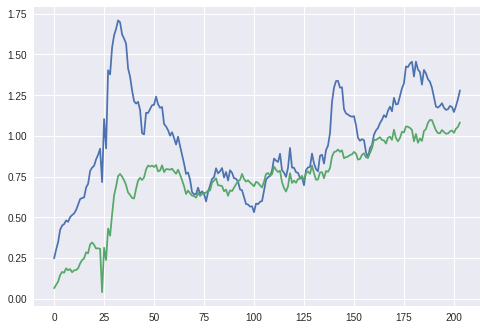

In [275]:
plt.plot(y_pred)
plt.show()

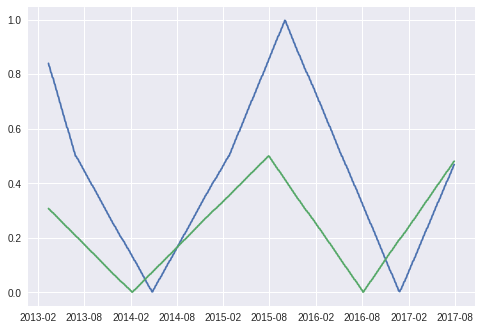

In [276]:
plt.plot(y)
plt.show()